# Проектная работа - AB тестирование

## Постановка задачи

Заказчик исследование -  аналитический отдел магазина.
Результат настоящего исследования - оценка корректности проведения A/B теста и анализ его результатов.



## План выполнения работ

1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ
   * График кумулятивной выручки по группам
   * Графики кумулятивного среднего чека по группам
   * График относительного изменения группы B к группе A
   * График кумулятивного среднего количества заказов по группам
   * График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
   * Точечный график количесва заказов
   * Определяем границу выбросов
   * Подсчет статистической значимости различий между группами
4. Выводы   

## Обзор данных

In [55]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as st
pd.options.display.float_format = '{: .2f}'.format
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [2]:
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/E6BsxxAyO5082g')
visitors = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Yqjm1iNvA26N2w')

In [3]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [6]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
len_a = len(orders.query('group == "A"')['visitorId'].unique())
len_b = len(orders.query('group == "B"')['visitorId'].unique())
len_ab = len(orders['visitorId'].unique())
len_av = visitors.query('group == "A"')['visitors'].sum()
len_bv = visitors.query('group == "B"')['visitors'].sum()
len_abv = visitors['visitors'].sum()

In [8]:
print(f"В группе A датафрейма orders {len_a} клиентов, что составляет {len_a/len_ab:.2%} от всех клиентов")
print(f"В группе B датафрейма orders {len_b} клиентов, что составляет {len_b/len_ab:.2%} от всех клиентов")

В группе A датафрейма orders 503 клиентов, что составляет 48.79% от всех клиентов
В группе B датафрейма orders 586 клиентов, что составляет 56.84% от всех клиентов


In [9]:
print(f"В группе A датафрейма visitors {len_av} посетителей, что составляет {len_av/len_abv:.2%} от всех посетителей")
print(f"В группе B датафрейма visitors {len_bv} посетителей, что составляет {len_bv/len_abv:.2%} от всех посетителей")

В группе A датафрейма visitors 18736 посетителей, что составляет 49.76% от всех посетителей
В группе B датафрейма visitors 18916 посетителей, что составляет 50.24% от всех посетителей



Напишем функцию для измерения равномерности распределения групп


In [10]:
def check_prop(num1, num2, num3, num4):
  count = np.array([num1,num3 ])
  nobs = np.array([num2, num4])
  alpha = 0.05
  stat, pval = proportions_ztest(count, nobs)
  print(pval)
  if pval < alpha:
    print(f"Отвергаем нулевую гипотезу. Пропорции статистически различимы.")
  else:
    print(f"Нулевую гипотезу отвергнуть не удалось")

In [11]:
check_prop(len_av, len_abv, len_bv, len_abv)

0.1895612721687402
Нулевую гипотезу отвергнуть не удалось


**Наблюдения:**


В нашем распоряжени два датасета:
Датасет **orders** содержит информацию о заказах

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Всего в датасете 1197 строк, пропусков нет


Датасет **visitors** содержит информациюо посетителях сайта
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Насколько я поняла из условия задачи мы предполагаем, что число 'visitors' - это именно число уникальных посетителей, а не пользовательских сессий

Мы видим, что группы A и B распределены равномерно.




## Предобработка данных

Проверим данные на наличие дубликатов и пропусков

In [19]:
print(orders.duplicated().sum())
print(visitors.duplicated().sum())
print(orders.isna().sum())
print(visitors.isna().sum())

0
0
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
date        0
group       0
visitors    0
dtype: int64


Проверим, не попадают ли пользователи с одинаквыми id одновременно в группы A и B

In [12]:
lista = list(orders.query('group == "A"')['visitorId'].unique())
listb = list(orders.query('group == "B"')['visitorId'].unique())

In [13]:
doubles = [x for x in lista if x in listb]

In [14]:
len(doubles)

58

Мы видим, что 58 пользователя в табличке 'orders' попали в разных трансакциях в разные группы. Придется их из исследования исключить

In [15]:
order = orders.query('visitorId not in @doubles')

Мы удалили из датафрейма покупки тех пользоваелей, которые одновременно попали в обе группы

### Результаты предобработки данных

* Мы убедились, что в обиох датасетах отсутсвуют дубликаты
* Пропуски отсутсвуют
* Мы обнаружили 58 посетителя, которые попали одновременно  в группу A группу B, мы их удалили из датасета.

## Исследовательский анализ

### 3.1 Построим график кумулятивной выручки

In [18]:
def cumulativeD(df1, df2):
  datesGroups = df1[['date', 'group']].drop_duplicates()
  ordersAggregated = (datesGroups.apply
   (lambda x: df1[np.logical_and(df1['date'] <= x['date'], df1['group'] == x['group'])]
    .agg({'date': 'max','group': 'max','transactionId': 'nunique','visitorId': 'nunique','revenue': 'sum'}),axis=1)
   .sort_values(by=['date', 'group']))
  visitorsAggregated = (datesGroups.apply
   (lambda x: df2[np.logical_and(df2['date'] <= x['date'], df2['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),axis=1)
   .sort_values(by=['date', 'group']))
  cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
  cumulativeData.columns = ['date','group','orders','buyers','revenue','visitors']
  cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders', 'visitors']]
  cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders', 'visitors']]
  return cumulativeData, cumulativeRevenueA, cumulativeRevenueB

In [19]:
cumulativeData, cumulativeRevenueA, cumulativeRevenueB = cumulativeD(order, visitors)

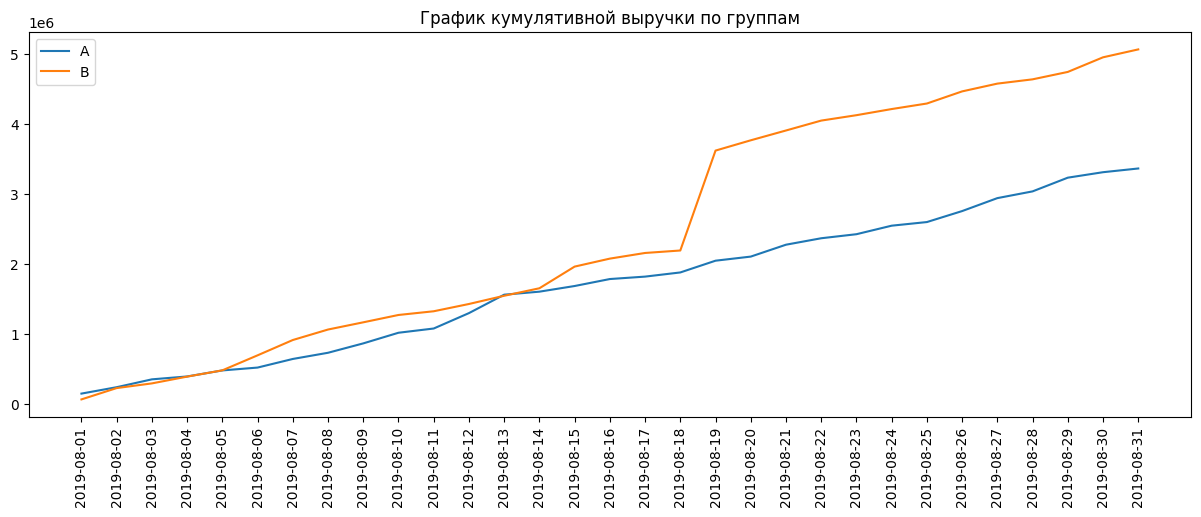

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.xticks(rotation=90)
plt.show()

В средине эксперимента мы видим, что группа B начинает заметно лидировать по выручке. Однако на этом этапе мы не можем делать никаких выводов о самих группах, так как мы не исследовали выбросы, а также потому, что у нас не идентично число посетителей в обоих группах

### 3.2.Построим график кумулятивного среднего чека по группам

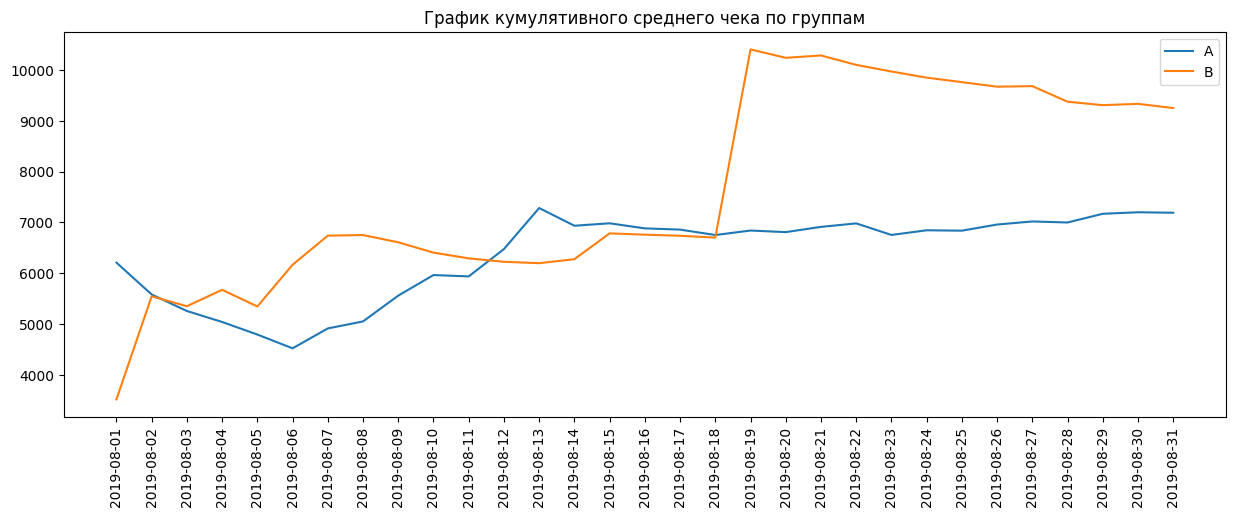

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Примерно в тот же период (середина проведения эксперимента, 15 августа) средний чек резко растет, но в дальнейшем мы рост не наблюдаем. Такое поведение графика моет быть связано с единичным выбросом.

### 3.3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

In [25]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [26]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [27]:
mergedCumulativeRevenue.sample()

,date,revenueA,ordersA,revenueB,ordersB
2,2019-08-03,346854,66,288850,54


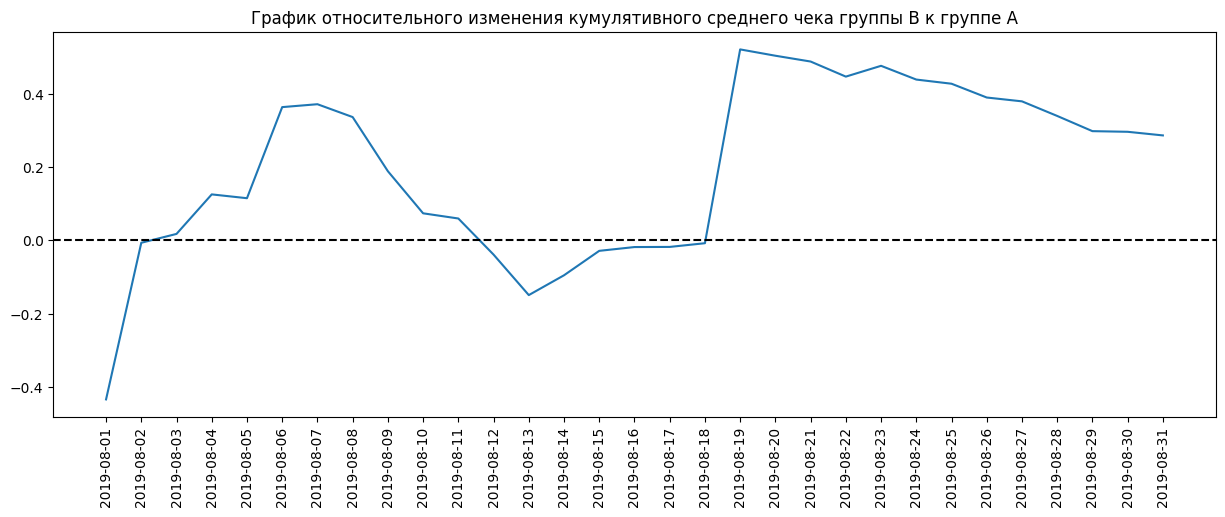

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=90)
plt.show()

График резко менял свое направление несколько раз. Начиная с середины теста значения группы B были более высокими, чем у группы A, однако для нас также важен анализ данных после удаления аномальных заказов

### 3.4.Построим график кумулятивного среднего количества заказов на посетителя по группам.

In [29]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

In [30]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.03
1,2019-08-01,B,17,17,59758,713,0.02
2,2019-08-02,A,42,36,234381,1338,0.03
3,2019-08-02,B,40,39,221801,1294,0.03
4,2019-08-03,A,66,60,346854,1845,0.04


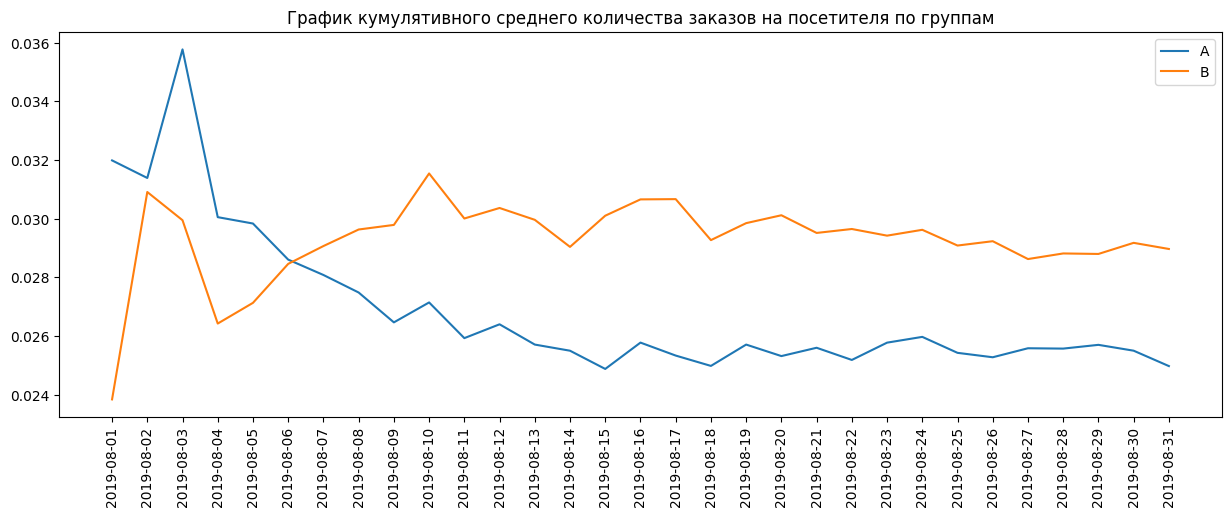

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.show()


В первые дни график колеблется, но в дальнейшем среднее количество заказов на посетителя заметно больше в группе B

### 3.5 Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [32]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']],
                                      left_on='date', right_on='date', how='left', suffixes=['A', 'B']))

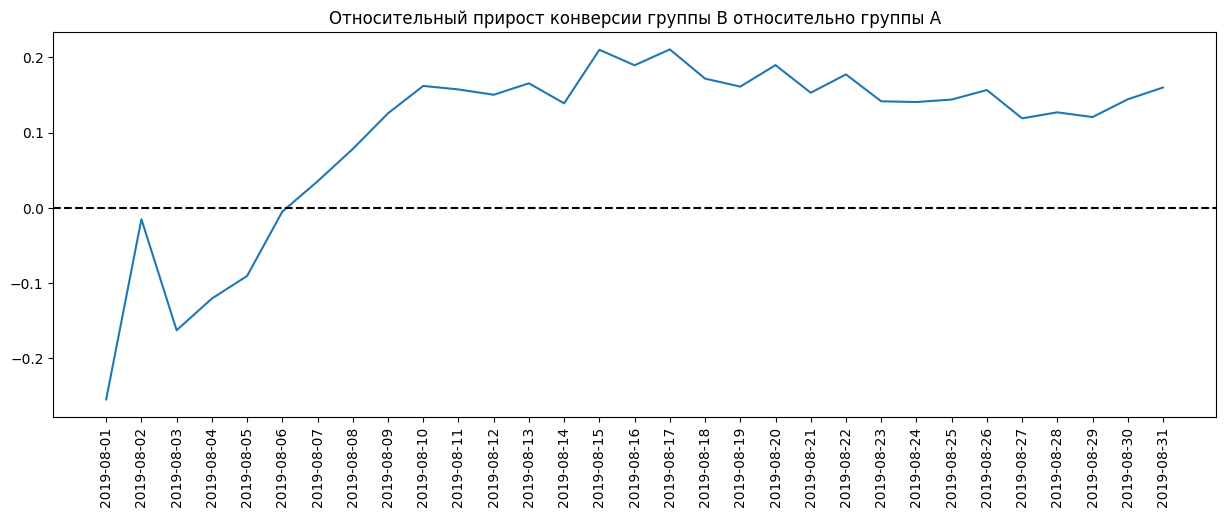

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xticks(rotation=90)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Этот график подтверждает наши наблюдения - конверсия группы заметно лучше конверсии группы A

### 3.6.Построим точечный график количества заказов по пользователям.

In [34]:
ordersByUsers = order.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']

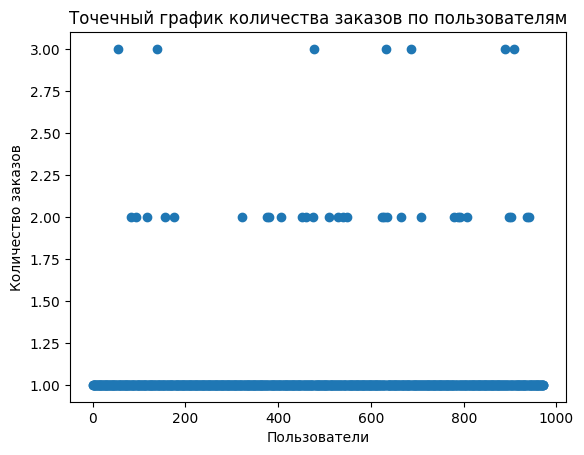

In [35]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Большинство пользователей совершают 1, максимум 2 заказа

### 3.7.Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

Выберем границу для определения аномальных пользователей.

In [36]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5 % пользователей совершали более 1 заказов,  и не более 1% пользоваьелей соверщал более 2 заказов. Определим 99 перцентиль как границу аномалий

### 3.8.Построим точечный график стоимостей заказов.

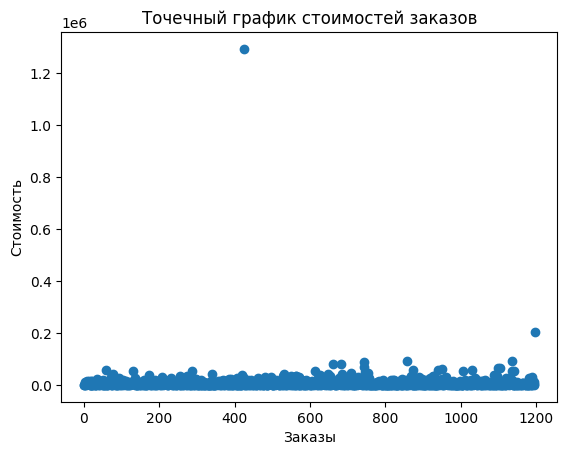

In [37]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

In [38]:
order['revenue'].describe()

count       1016.00
mean        8300.81
std        42121.99
min           50.00
25%         1190.00
50%         2955.00
75%         8134.25
max      1294500.00
Name: revenue, dtype: float64

Стоимость заказа колеблется от 50 до 18900. Но есть единичные выбросы

### 3.9.Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [40]:
np.percentile(order['revenue'], [95, 99])

array([26785., 53904.])

Не более, чем у 5% заказов чек дороже 26785, не более чем у 1% заказов чек дороже 53904. В дальнейшем мы возьмем за основу 95 перцентиль, которым обозначим границу выбросов

### 3.10.Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем статистические гипотезы:

H_0: В группах A и B нет статистического различия между количеством заказов на посетителя

H_1: В группах A и B есть статистические различия между количеством заказов на посетителя

alpha = 0.05

In [41]:
def make_sample(df1, df2):
  ordersByUsersA = (
    df1[df1['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
  ordersByUsersA.columns = ['userId', 'orders']
  revenueByUsersA = (
    df1[df1['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'revenue': 'sum'}))
  revenueByUsersA.columns = ['userId', 'revenue']
  ordersByUsersB = (
    df1[df1['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))
  ordersByUsersB.columns = ['userId', 'orders']
  revenueByUsersB = (
    df1[df1['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'revenue': 'sum'}))
  revenueByUsersB.columns = ['userId', 'revenue']
  sampleA = (pd.concat([ordersByUsersA['orders'],
                        pd.Series(0, index=np.arange(df2.query('group== "A"')['visitors'].sum()
                         - len(ordersByUsersA['orders'])), name='orders')],axis=0))
  sampleB = (pd.concat([ordersByUsersB['orders'],pd.Series
      (0, index=np.arange(df2.query('group== "B"')['visitors'].sum()
       - len(ordersByUsersB['orders'])), name='orders')],axis=0))
  sampleAr = (pd.concat([revenueByUsersA['revenue'],
                        pd.Series(0, index=np.arange(df2.query('group== "A"')['visitors'].sum()
                         - len(revenueByUsersA['userId'])), name='revenue')],axis=0))
  sampleBr = (pd.concat([revenueByUsersB['revenue'],pd.Series
      (0, index=np.arange(df2.query('group== "B"')['visitors'].sum()
       - len(revenueByUsersB['userId'])), name='revenue')],axis=0))
  return sampleA, sampleB, sampleAr, sampleBr, ordersByUsersA, ordersByUsersB

Мы написали функцию, которая получает на вход два датафрейма. (Мы ее будем использовать для сырых и очищенных данных)
На выходе мы получаем

sampleA, sampleB - массивы количества заказов на человека( включая нули для тех, кто не совершал покупки) для проведения статистического анализа

sampleAr, sampleBr - массивы сумм покупок для каждого посетителя, включая нули, эти массивы мы используем в дальнейшем

ordersByUsersA, ordersByUsersB - массивы количества заказов для каждого покупателя

U-критерий Манна — Уитни для оценки различий между двумя независимыми выборками

In [53]:
def mwtest(sample1,sample2, num):
  alpha = 0.05
  results1 = st.mannwhitneyu(sample1, sample2)[1]
  print('p-значение, u-критерий Манна-Уитни:', results1)
  print('средние значения sample1', round(sample1.mean(),2))
  print('средние значения sample2', round(sample2.mean(),2))
  if num == 2:
    if results1 < alpha:
      print("Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между двумя выборками.")
    else:
      print("Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между двумя выборками.")
  if num == 1:
    if results1 < alpha:
      print("Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между двумя выборками.")
    else:
      print("Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между двумя выборками.")

In [48]:
sampleA, sampleB, sampleAr, sampleBr, ordersByUsersA, ordersByUsersB = make_sample(order, visitors)

In [56]:
mwtest(sampleA,sampleB, 2)

p-значение, u-критерий Манна-Уитни: 0.011018084110014696
средние значения sample1 0.02
средние значения sample2 0.03
Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между двумя выборками.


In [58]:
0.03-0.02/0.02

-0.97

In [60]:
sampleA.mean()

0.02497865072587532

In [57]:
print(f" Средние значения количества заказов на посетителя группы B отличаются от средних значений группы A  на {((sampleB.mean() / sampleA.mean() - 1)*100):.2F} % ")

 Средние значения количества заказов на посетителя группы B отличаются от средних значений группы A  на 15.98 % 


**Выводы:**

* Нулевую гипотезу мы отвергаем
* Анализ сырых данных показывает, что в среднем количестве заказов есть статистически значимые различия.
* Относительный прирост среднего группы B к конверсии группы A равен 16%

### 3.11.Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем статистические гипотезы:

H_0: В группах A и B нет статистического различия в среднем чеке на покупателя

H_1: В группах A и B есть статистические различия в среднем чеке на покупателя
alpha = 0.05

In [64]:
sample1 = orders[orders['group']=='A']['revenue']
sample2 = orders[orders['group']=='B']['revenue']

In [67]:
mwtest(sample1, sample2, 2)

p-значение, u-критерий Манна-Уитни: 0.7292909855432458
средние значения sample1 7333.58
средние значения sample2 9230.88
Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между двумя выборками.


**Выводы:**

 Мы не можем отвергнуть 0 гипотезу, статистических различий между группами мы не наблюдаем.


### 3.12.Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Сформулируем статистические гипотезы:

H_0: В группах A и B в очищенных от аномалий данных нет статистического различия между количеством заказов на посетителя

H_1: В группах A и B в очищенных от аномалий данных есть статистические различия между количеством заказов на посетителя

alpha = 0.05


Приступаем к подготовке очищенных от аномалий данных.
Напомним, что 95-й и 99-й перцентили средних чеков равны
28000 и 58233 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.
Примем за аномальных пользователей тех, кто совершил больше 2 заказов  или совершил заказ на сумму 28000 и более рублей.


In [68]:
sampleA, sampleB, sampleAr, sampleBr, ordersByUsersA, ordersByUsersB = make_sample(order, visitors)

In [73]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

In [74]:
perco = np.percentile(ordersByUsers['orders'], [99])[0]
percr = np.percentile(order['revenue'], [95])[0]

In [75]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > perco]['userId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > perco]['userId']],axis=0)

In [78]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > perco]['userId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > perco]['userId']],axis=0)
usersWithExpensiveOrders = order[order['revenue'] >= percr]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [79]:
au = list(abnormalUsers)
orders_norm = order.query('visitorId not in @au')

In [82]:
sampleAfilter, sampleBfilter, sampleArfilter, sampleBrfilter, ordersByUsersA, ordersByUsersB = make_sample(orders_norm, visitors)

In [81]:
mwtest(sampleAfilter, sampleBfilter, 2)

p-значение, u-критерий Манна-Уитни: 0.012459950618584474
средние значения sample1 0.02
средние значения sample2 0.03
Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между двумя выборками.


In [83]:
print(f" Средние значения количества заказов на посетителя в очищенных датафреймах группы B отличаются от средних значений группы A  на {((sampleBfilter.mean() / sampleAfilter.mean() - 1)*100):.2F} % ")

 Средние значения количества заказов на посетителя в очищенных датафреймах группы B отличаются от средних значений группы A  на 18.17 % 


**Выводы:**

* Результаты очень близкик результатам сырых данных, нулевую гипотезу мы отвергаем
* В среднем количестве заказов есть статистически значимые различия
Относительные прирост среднего группы B к конверсии группы A равен 18%

### 3.13 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем статистические гипотезы:

H_0: В группах A и B  в очищенных данных нет статистического различия в среднем чеке на покупателя

H_1: В группах A и B в очищенных данных есть статистические различия в среднем чеке на покупателя

alpha = 0.05

In [84]:
lA = order[np.logical_and(order['group'] == 'A', np.logical_not(order['visitorId'].isin(abnormalUsers)))]['revenue']

In [85]:
lB = order[np.logical_and(order['group'] == 'B',np.logical_not(order['visitorId'].isin(abnormalUsers)))]['revenue']

In [86]:
mwtest(lA, lB, 2)

p-значение, u-критерий Манна-Уитни: 0.6458964038091206
средние значения sample1 5102.51
средние значения sample2 4855.19
Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между двумя выборками.


**Выводы:**

 Мы не можем отвергнуть 0 гипотезу, статистических различий между группами мы не наблюдаем.

## Дополнительная гипотеза

Прежде, чем делать вывод, проверим еще одну гипотезу. Мы ранее сравнивали средние чеки среди покупателей и среднее количество заказов среди всех посетителей. Построим график кумулятивной ARPU каждой из групп

In [88]:
cumulativeData1, cumulativeRevenueA1, cumulativeRevenueB1 = cumulativeD(orders_norm, visitors)

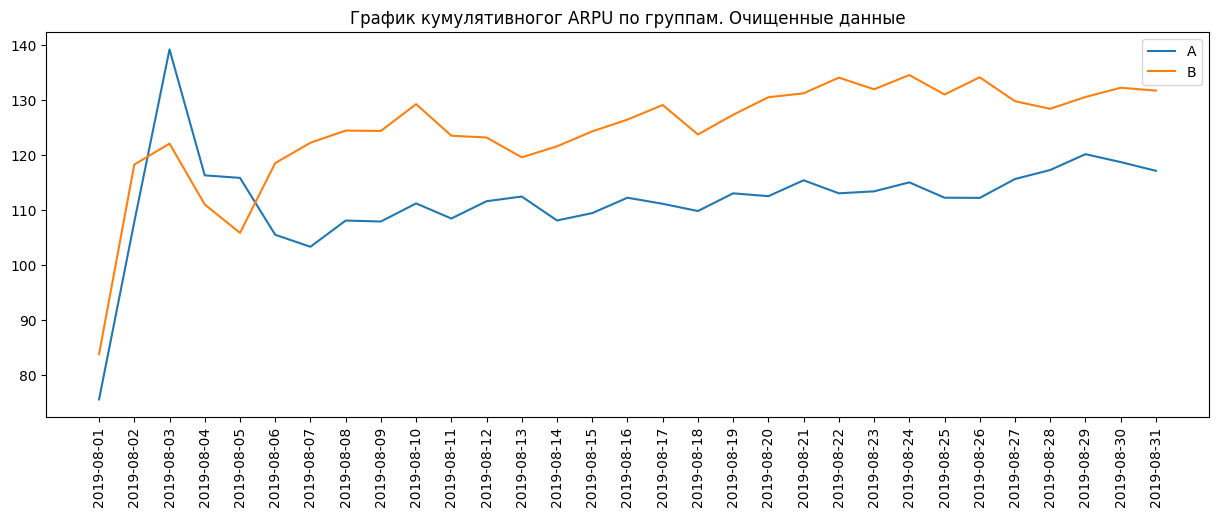

In [94]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA1['date'], cumulativeRevenueA1['revenue']/cumulativeRevenueA1['visitors'], label='A')
plt.plot(cumulativeRevenueB1['date'], cumulativeRevenueB1['revenue']/cumulativeRevenueB1['visitors'], label='B')
plt.title('График кумулятивногог ARPU по группам. Очищенные данные')
plt.legend()
plt.xticks(rotation=90)
plt.show()

Сформулируем статистические гипотезы:

H_0: В группах A и B  в очищенных данных нет статистического различия в средней выручке с посетителя  

H_1: В группах A и B  в очищенных данных есть статистические различия в средней выручке с посетителя  

alpha = 0.05

In [90]:
sampleA1, sampleB1, sampleAr1, sampleBr1, ordersByUsersA1, ordersByUsersB1 = make_sample(orders_norm, visitors)

In [91]:
mwtest(sampleA1, sampleB1, 2)

p-значение, u-критерий Манна-Уитни: 0.012459950618584474
средние значения sample1 0.02
средние значения sample2 0.03
Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между двумя выборками.


In [93]:
print(f"Средняя выручка на посетителя в группе B  отличаются от средней выручки на посетителя группы A  на {((sampleBr1.mean() / sampleAr1.mean() - 1)*100):.2F} %")

Средняя выручка на посетителя в группе B  отличаются от средней выручки на посетителя группы A  на 12.44 %


Мы видим, что по показателям ARPU (мы сравнивали два массиива где на каждого посетителя подсчитывалась сумма его покупок, а также добавлялись нули для всех некупивших посетителей) статистическая значимость обнаружена и мы можем отвергнуть нулевую гипотезу.

Мы также наблюдаем прирост средней выручки в группе B

## Выводы



Сравнивая группы A и B мы можем наблюдать явное статистическое различие по количеству заказов на пользователя. При этом в группе B заказов на 13-16% больше, относительно группы A

Сраавнивая группы A и B по среднему чеку заказа мы не видим явных статистических различий между группами.

Построив график кумулятивногог ARPU  на очищенных данных мы видим, что группа B приносит больше прибыли  примерно на 12%, по сравнению с группой A.

Таким образом мы можем делать предварительный выбор в пользу группы B

Замечания: Наши выводы основывались на предположении, что все цифры посетителей сайта обозначали уникальных посетителей. В случае, если одни и те же посетители могли посещать сайт несколько раз и были подсчитаны несколько раз, мы лишаемся возможности подсчитывать средний доход на пользователя, так же как и среднее количество заказов на посетителя, и можем только изучать детально оплативших клиентов из датафрейма orders.